R shape (images, neurons): (118, 39209)
ViT logits shape: (118, 1000)
Label balance (n_ones, n_zeros): 58 60
Neural PCs shape: (118, 100)
Logistic weights shape: (100,)


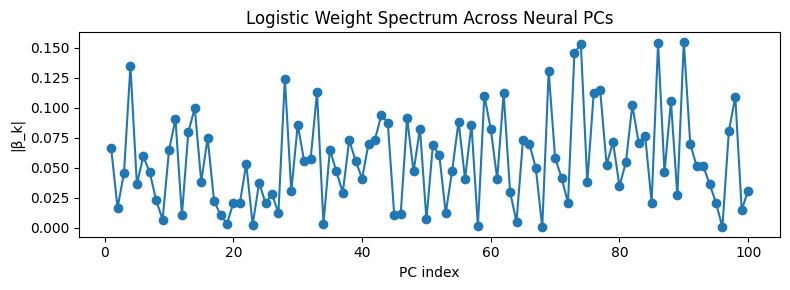

Fisher diagonal shape: (100,)


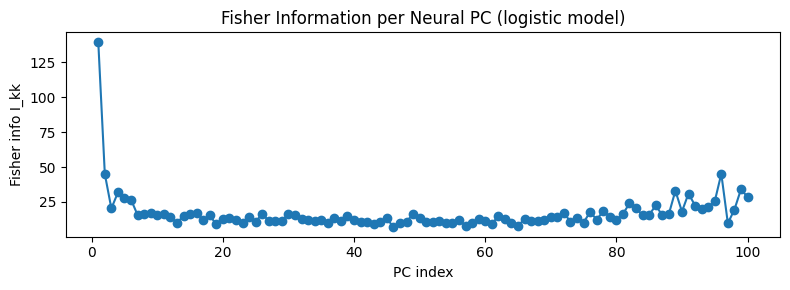

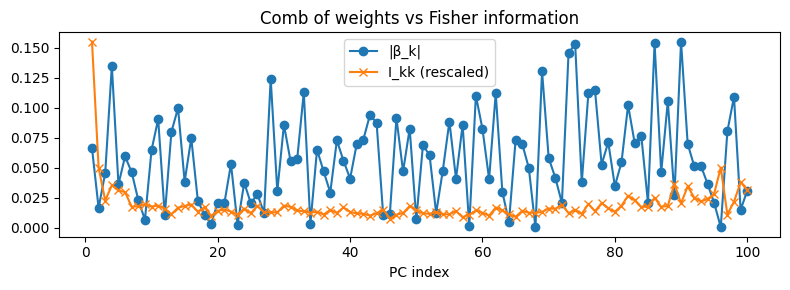

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# 0. Paths (from your message)
# ---------------------------------------------------------

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

# ---------------------------------------------------------
# 1. Load data
# ---------------------------------------------------------

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']  # dict or array depending on your file
R     = np.load(NEURAL_PATH).T                                   # shape: (images, neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)                  # (neurons,)

print("R shape (images, neurons):", R.shape)

# ---------------------------------------------------------
# 2. Build animate / inanimate labels from ViT logits
#    (simple proxy: sign of PC1 of logits)
# ---------------------------------------------------------

# vit is often a dict: {"embeddings": arr} or similar.
# If it's already an array of shape (images, classes), adjust this.
if isinstance(vit, dict):
    vit_logits = vit['logits']      # <-- change this key if needed
else:
    vit_logits = vit               # assume it's already the array

print("ViT logits shape:", vit_logits.shape)

# PCA on logits, get PC1
pca_vit = PCA(n_components=5)
vit_pcs = pca_vit.fit_transform(vit_logits)  # shape: (images, 5)
pc1 = vit_pcs[:, 0]

# Binary label based on PC1 sign
y = (pc1 > 0).astype(int)
print("Label balance (n_ones, n_zeros):", y.sum(), len(y) - y.sum())

# ---------------------------------------------------------
# 3. PCA on neural responses
# ---------------------------------------------------------

# Standardize per neuron (important before PCA)
scaler = StandardScaler()
R_std = scaler.fit_transform(R)

n_pcs = min(100, R_std.shape[1])
pca_neural = PCA(n_components=n_pcs)
X = pca_neural.fit_transform(R_std)   # X: (images, n_pcs)

print("Neural PCs shape:", X.shape)

# ---------------------------------------------------------
# 4. Fit logistic regression on neural PCs
# ---------------------------------------------------------

clf = LogisticRegression(max_iter=5000)
clf.fit(X, y)

beta = clf.coef_.ravel()    # shape: (n_pcs,)
b0   = clf.intercept_[0]

print("Logistic weights shape:", beta.shape)

# Optional: comb spectrum of |beta|
plt.figure(figsize=(8,3))
plt.plot(np.arange(1, n_pcs+1), np.abs(beta), marker='o')
plt.xlabel("PC index")
plt.ylabel("|β_k|")
plt.title("Logistic Weight Spectrum Across Neural PCs")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 5. Fisher information for logistic regression
# ---------------------------------------------------------

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# logits for each sample
g = X @ beta + b0                     # shape: (N,)
p = sigmoid(g)                        # predicted P(y=1)

# Diagonal weight terms: p(1-p)
w_diag = p * (1 - p)                  # shape: (N,)

# Fisher matrix: F = X^T W X, with W = diag(w_diag)
# Efficient computation using broadcasting
# (X.T * w_diag) @ X gives same as X^T W X
F = (X.T * w_diag) @ X                # shape: (n_pcs, n_pcs)

# Diagonal = Fisher info per PC in this basis
fisher_diag = np.diag(F)

print("Fisher diagonal shape:", fisher_diag.shape)

# ---------------------------------------------------------
# 6. Plot Fisher information spectrum across PCs
# ---------------------------------------------------------

plt.figure(figsize=(8,3))
plt.plot(np.arange(1, n_pcs+1), fisher_diag, marker='o')
plt.xlabel("PC index")
plt.ylabel("Fisher info I_kk")
plt.title("Fisher Information per Neural PC (logistic model)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 7. Optional: compare FI vs |β|^2
# ---------------------------------------------------------

plt.figure(figsize=(8,3))
plt.plot(np.arange(1, n_pcs+1), np.abs(beta), label="|β_k|", marker='o')
plt.plot(np.arange(1, n_pcs+1), fisher_diag / fisher_diag.max() * np.abs(beta).max(),
         label="I_kk (rescaled)", marker='x')
plt.xlabel("PC index")
plt.legend()
plt.title("Comb of weights vs Fisher information")
plt.tight_layout()
plt.show()


R: (118, 39209) ViT logits: (118, 1000)
Label counts: [60 58]
Neural PCs: (118, 118)


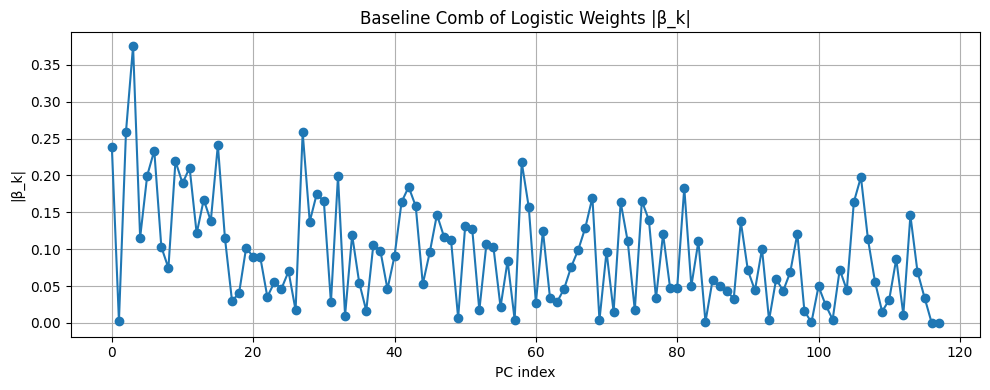

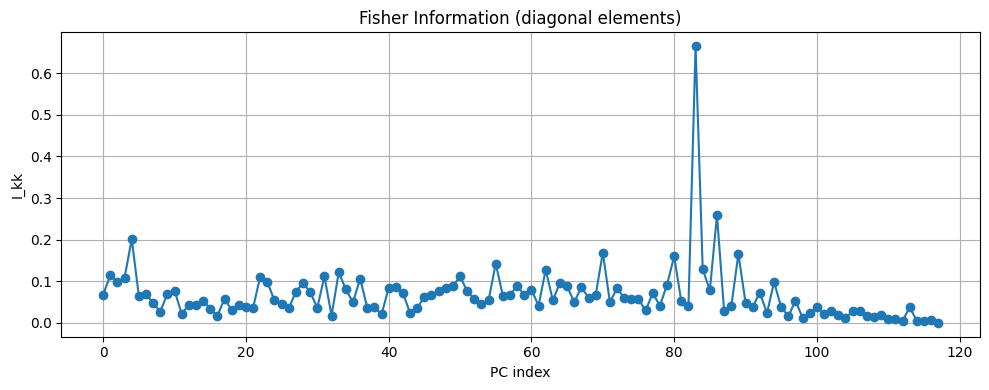

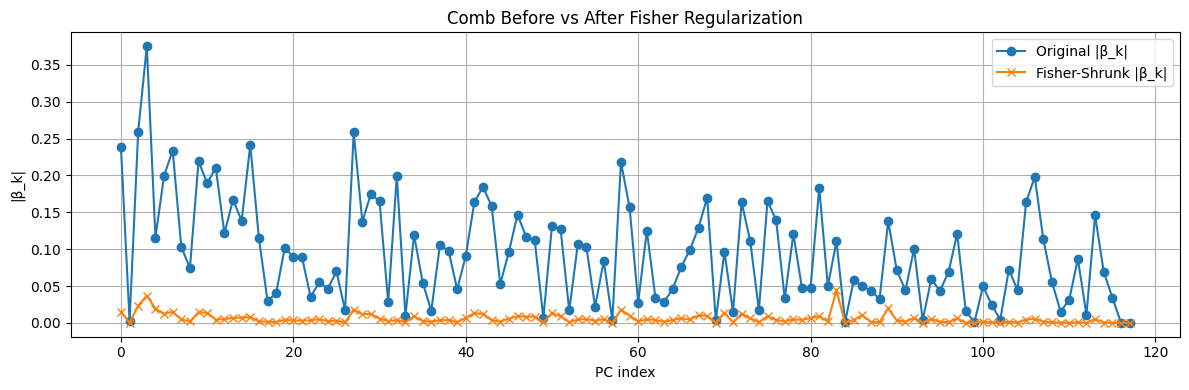

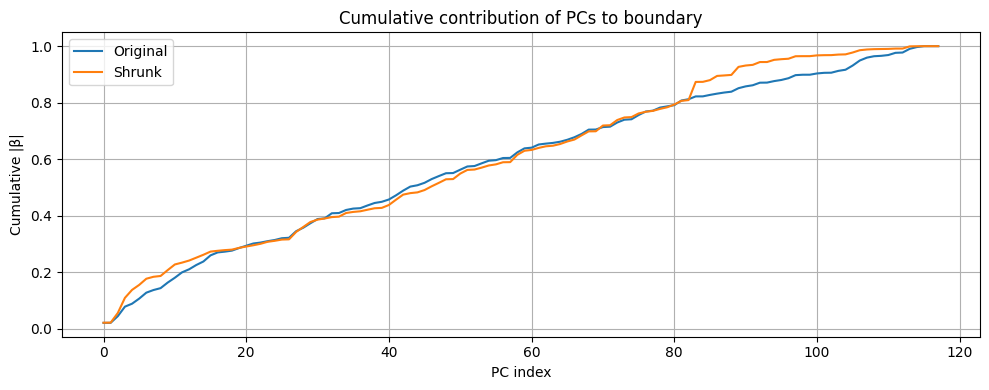

Total |beta|: 11.102321731738295
Total |beta_shrunk|: 0.6877151378532553


In [ ]:
#https://chatgpt.com/g/g-p-691779d6d19c81918af976cc7c5b41c4-projectiontheory/c/6935dd2e-0820-8330-b048-06d71c27768a

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1) LOAD DATA
# ============================================================

VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

vit_data = np.load(VIT_PATH, allow_pickle=True)
R = np.load(NEURAL_PATH).T                   # (images, neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)

# vit_data is often a dict; adjust depending on your file
if isinstance(vit_data, dict):
    vit_logits = vit_data['natural_scenes']
else:
    vit_logits = vit_data

print("R:", R.shape, "ViT logits:", vit_logits.shape)

# ============================================================
# 2) BUILD LABELS (PC1 of ViT logits)
# ============================================================

pca_vit = PCA(n_components=5)
vit_pcs = pca_vit.fit_transform(vit_logits)
pc1 = vit_pcs[:, 0]

y = (pc1 > 0).astype(int)
print("Label counts:", np.bincount(y))

# ============================================================
# 3) PCA ON NEURAL RESPONSES
# ============================================================

scaler = StandardScaler()
R_std = scaler.fit_transform(R)

n_pcs = min(118, R_std.shape[1])  # use 120 PCs max
pca_neural = PCA(n_components=n_pcs)
X = pca_neural.fit_transform(R_std)   # neural PCs

variances = pca_neural.explained_variance_   # variance per PC

print("Neural PCs:", X.shape)

# ============================================================
# 4) LOGISTIC REGRESSION (BASELINE COMB)
# ============================================================

clf = LogisticRegression(max_iter=5000, penalty=None)
clf.fit(X, y)
beta = clf.coef_.ravel()
b0 = clf.intercept_[0]

# Baseline comb
plt.figure(figsize=(10,4))
plt.plot(np.abs(beta), marker='o')
plt.title("Baseline Comb of Logistic Weights |β_k|")
plt.xlabel("PC index")
plt.ylabel("|β_k|")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 5) FISHER INFORMATION FOR LOGISTIC REGRESSION
# ============================================================

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

g = X @ beta + b0
p = sigmoid(g)
w_diag = p * (1 - p)                   # p(1-p) weighting

# Fisher matrix F = X^T diag(w) X
F = (X.T * w_diag) @ X
fisher_diag = np.diag(F) + 1e-12       # prevent division by zero

plt.figure(figsize=(10,4))
plt.plot(fisher_diag, marker='o')
plt.title("Fisher Information (diagonal elements)")
plt.xlabel("PC index")
plt.ylabel("I_kk")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 6) FISHER-WEIGHTED SHRINKAGE OF LOGISTIC WEIGHTS
# ============================================================

lambda_reg = 1.0   # try stronger or weaker regularization

beta_shrunk = beta / (1 + lambda_reg / fisher_diag)

# ============================================================
# 7) COMPARE COMBS: BEFORE VS AFTER REGULARIZATION
# ============================================================

plt.figure(figsize=(12,4))
plt.plot(np.abs(beta), label="Original |β_k|", marker='o')
plt.plot(np.abs(beta_shrunk), label="Fisher-Shrunk |β_k|", marker='x')
plt.title("Comb Before vs After Fisher Regularization")
plt.xlabel("PC index")
plt.ylabel("|β_k|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 8) ALSO COMPARE AGGREGATION: TOTAL WEIGHT IN HIGH-ORDER PCs
# ============================================================

plt.figure(figsize=(10,4))
plt.plot(np.cumsum(np.abs(beta)) / np.sum(np.abs(beta)), label="Original")
plt.plot(np.cumsum(np.abs(beta_shrunk)) / np.sum(np.abs(beta_shrunk)), label="Shrunk")
plt.title("Cumulative contribution of PCs to boundary")
plt.xlabel("PC index")
plt.ylabel("Cumulative |β|")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Total |beta|:", np.sum(np.abs(beta)))
print("Total |beta_shrunk|:", np.sum(np.abs(beta_shrunk)))
